In [1]:
# Algorithms
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  
sys.path.append(project_root)

from image_deblurring.algorithms_deblurring import *
import numpy as np
import scipy.ndimage
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import cv2
import pickle

#### Load original image

In [2]:
# Load the original image
image = imageio.imread(os.path.join(project_root, 'image_deblurring/photos/original.jpg'), mode="L")  
image = image.astype(np.float64) 


# Reshape the image for computational cost reasons
n1, n2 = 584, 238
image = scipy.ndimage.zoom(image, (n1 / image.shape[0], n2 / image.shape[1]), order=1)

In [13]:
# Save the reshaped image
path_original_reshaped = os.path.join(project_root, 'image_deblurring/photos/original_reshaped.jpg')
cv2.imwrite(path_original_reshaped, image)

True

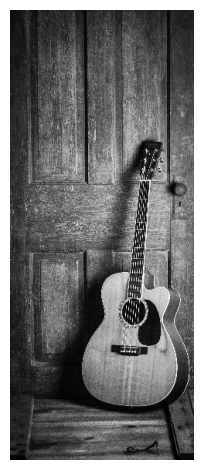

In [3]:
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

#### Generate blurred image

In [4]:
# Generate blurring matrix
H = generate_blur_matrix(n1, n2, 10)

# Generate observed image (y = Hx + noise)
sigma = 0.47
y = H @ image.flatten() + np.random.normal(0, sigma, size=(n1 * n2))
y = y.reshape(n1, n2)

In [14]:
# Save the blurred observed image
path_blurred = os.path.join(project_root, 'image_deblurring/photos/blurred.jpg')
cv2.imwrite(path_blurred, y)

True

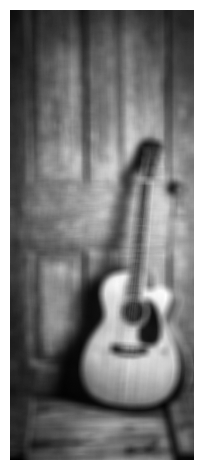

In [5]:
plt.imshow(y, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

#### Auxiliary functions

In [6]:
# Compute discrete gradient operator
Dx, Dy = discrete_gradient(n1, n2)

In [7]:
N = 10
sigma_init = 10
w_init = np.random.normal(50, sigma_init, size=(n1, n2, N))
method_tv = "dr"  # dr or chambolle

theta_initial = np.random.uniform(-15, 10, size = 1)[0]

#### PIPGLA algorithm

In [8]:
samples_pipgla, nmse_pipgla, thetas_pipgla, mse_pipgla = pipgla(theta_initial, w_init, H, y, sigma, lambdaaa = 0.4, Dx = Dx, Dy = Dy, original = image, K=3000, h=0.01, method_tv=method_tv)
    

100%|██████████| 3000/3000 [12:55<00:00,  3.87it/s]


In [24]:
path_pipgla_tensor = os.path.join(project_root, 'image_deblurring/outputs/pipgla_particles.pkl')
# Save the tensor to a pickle file
with open(path_pipgla_tensor, "wb") as f:
    pickle.dump(samples_pipgla, f)

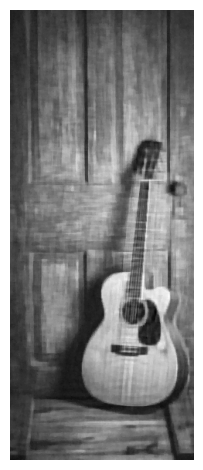

In [12]:
i = 0 # Index of one of the particles
plt.imshow(samples_pipgla[:, :, i], cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
# Save the blurred observed image
path_pipgla = os.path.join(project_root, 'image_deblurring/photos/pipgla_reconstructed.jpg')
cv2.imwrite(path_pipgla, samples_pipgla[:, :, i])

True

#### MYIPLA algorithm

In [9]:
samples_myipla, nmse_myipla, thetas_myipla, mse_myipla = myipla(theta_initial, w_init, H, y, sigma, lambdaaa = 0.4, Dx = Dx, Dy = Dy, original = image, K=3000, h=0.01, method_tv=method_tv)
    

100%|██████████| 3000/3000 [12:25<00:00,  4.02it/s]


In [23]:
path_myipla_tensor = os.path.join(project_root, 'image_deblurring/outputs/myipla_particles.pkl')
# Save the tensor to a pickle file
with open(path_myipla_tensor, "wb") as f:
    pickle.dump(samples_myipla, f)

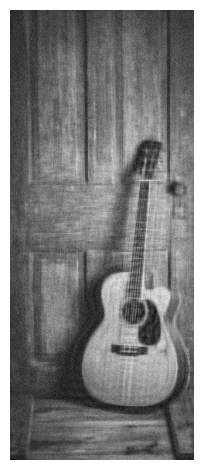

In [16]:
i = 0 # Index of one of the particles
plt.imshow(samples_myipla[:, :, i], cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
# Save the blurred observed image
path_myipla = os.path.join(project_root, 'image_deblurring/photos/myipla_reconstructed.jpg')
cv2.imwrite(path_myipla, samples_myipla[:, :, i])

True

#### MYPGD algorithm

In [10]:
samples_mypgd, nmse_mypgd, thetas_mypgd, mse_mypgd = mypgd(theta_initial, w_init, H, y, sigma, lambdaaa = 0.4, Dx = Dx, Dy = Dy, original = image, K=3000, h=0.01, method_tv=method_tv)
    

100%|██████████| 3000/3000 [12:12<00:00,  4.10it/s]


In [25]:
path_mypgd_tensor = os.path.join(project_root, 'image_deblurring/outputs/mypgd_particles.pkl')
# Save the tensor to a pickle file
with open(path_mypgd_tensor, "wb") as f:
    pickle.dump(samples_mypgd, f)

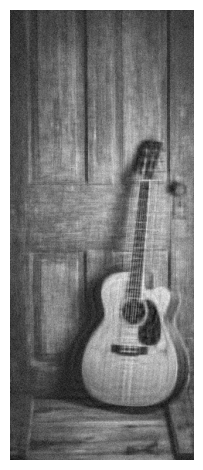

In [18]:
i = 0 # Index of one of the particles
plt.imshow(samples_mypgd[:, :, i], cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
# Save the blurred observed image
path_mypgd = os.path.join(project_root, 'image_deblurring/photos/mypgd_reconstructed.jpg')
cv2.imwrite(path_mypgd, samples_mypgd[:, :, i])

True

#### Evolution of parameter theta

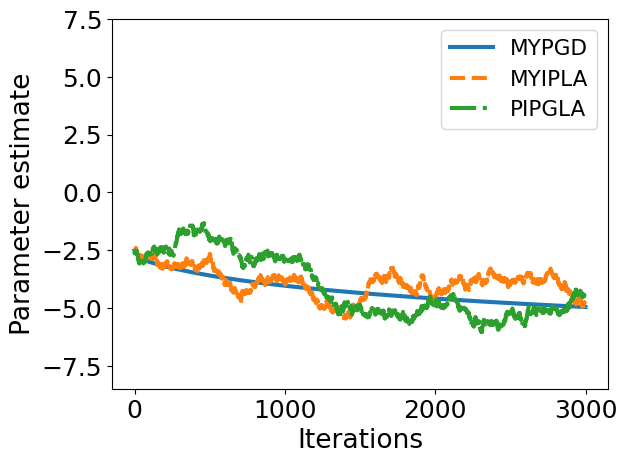

In [26]:
fig = plt.figure()

## MYPGD
plt.plot(thetas_mypgd, label = 'MYPGD', linewidth=2.95, linestyle = "solid")

## MYIPLA
plt.plot(thetas_myipla, label = 'MYIPLA', linewidth=2.95, linestyle='dashed')

## PIPGLA 
plt.plot(thetas_pipgla, label = 'PIPGLA', linewidth=2.95, linestyle = "dashdot")

plt.tick_params(labelsize=18)

# Labels and title
plt.xlabel('Iterations', fontsize=19)
plt.ylabel('Parameter estimate', fontsize=19)

plt.ylim(-8.5, 7.5)
plt.legend(fontsize=15.5, loc='upper right')


path_parameter_estimates_fig = os.path.join(project_root, 'image_deblurring/outputs/parameter_estimates.pdf')
fig.savefig(path_parameter_estimates_fig, format='pdf', bbox_inches='tight')

#### Error evolution

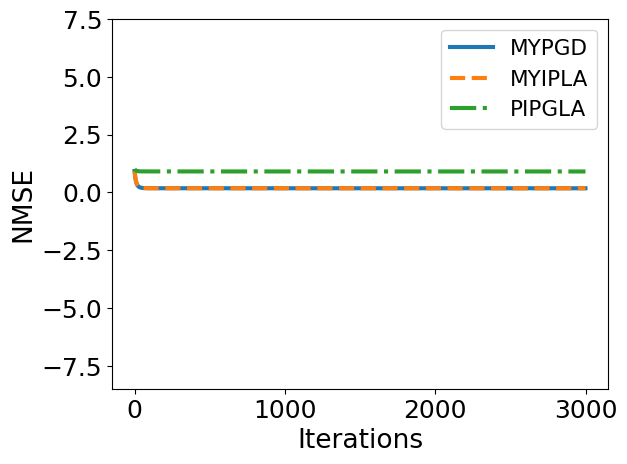

In [27]:
fig = plt.figure()

## MYPGD
plt.plot(nmse_mypgd, label = 'MYPGD', linewidth=2.95, linestyle = "solid")

## MYIPLA
plt.plot(nmse_myipla, label = 'MYIPLA', linewidth=2.95, linestyle='dashed')

## PIPGLA 
plt.plot(nmse_pipgla, label = 'PIPGLA', linewidth=2.95, linestyle = "dashdot")

plt.tick_params(labelsize=18)

# Labels and title
plt.xlabel('Iterations', fontsize=19)
plt.ylabel('NMSE', fontsize=19)

plt.ylim(-8.5, 7.5)
plt.legend(fontsize=15.5, loc='upper right')


path_evolution_nmse_fig = os.path.join(project_root, 'image_deblurring/outputs/evolution_nmse.pdf')
fig.savefig(path_evolution_nmse_fig, format='pdf', bbox_inches='tight')